### Notebook SP1 - Simulation of mRNA-protein data with non-constant protein decay rates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from scipy.integrate import odeint
from scipy.stats import beta, norm
from scipy.interpolate import interp1d
from itertools import product

In [2]:
sns.set_context('talk')
sns.set_style('white')

#### A) Data import and exploration of protein noise magnitude

In [3]:
protein_path = "input_data/protein_mRNA_data.xlsx"

In [4]:
# read spatial sorting data from combined file
combined_data = pd.read_excel(protein_path, index_col=0, header=0)
# fix excel strings
combined_data.index = [x[1:-1] for x in combined_data.index]

In [5]:
# split into protein and protein errors
P_data = combined_data[[x for x in combined_data.columns if
                        x.startswith('protein')]]
Psem_data = combined_data[[x for x in combined_data.columns if
                           x.startswith('SEM')]]

In [6]:
# rename to enable pandas division
P_data.columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Psem_data.columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [7]:
# get a dataframe with relative standard errors
Prse_data = Psem_data.div(P_data, axis=1)

In [8]:
# there are some nan's in here because of zeros in pdata
np.sum(np.isnan(Prse_data))

V1    333
V2    214
V3    201
V4    106
V5    106
V6     96
dtype: int64

array([[<AxesSubplot:title={'center':'V1'}>,
        <AxesSubplot:title={'center':'V2'}>],
       [<AxesSubplot:title={'center':'V3'}>,
        <AxesSubplot:title={'center':'V4'}>],
       [<AxesSubplot:title={'center':'V5'}>,
        <AxesSubplot:title={'center':'V6'}>]], dtype=object)

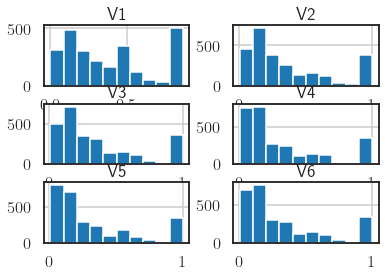

In [9]:
Prse_data.hist()

In [10]:
# genewise mean and std of RSE
Prse_mean = Prse_data.copy()
Prse_mean['mean RSE'] = Prse_data.mean(axis=1)
Prse_mean['std RSE'] = Prse_data.std(axis=1)
Prse_mean['mean sum'] = P_data.sum(axis=1)
Prse_mean['SEM sum'] = Psem_data.sum(axis=1)
Prse_mean['SEM sum/mean sum'] = Prse_mean['SEM sum']/Prse_mean['mean sum']
Prse_mean = Prse_mean.drop(['V1', 'V2', 'V3', 'V4', 'V5', 'V6'], axis=1)

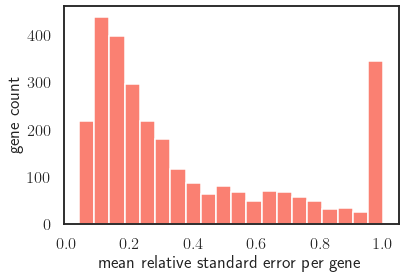

In [54]:
a = plt.hist(Prse_mean['mean RSE'], bins=20, color='salmon')
plt.xlabel('mean relative standard error per gene')
plt.ylabel('gene count')
plt.savefig('figures/data_RSE_histogramme.pdf', bbox_inches='tight')

In [12]:
Prse_mean[Prse_mean['mean RSE']<0.25]

,mean RSE,std RSE,mean sum,SEM sum,SEM sum/mean sum
Aadac,0.113482,0.077106,0.001527,0.000152,0.099543
Aak1,0.137127,0.084889,0.000045,0.000006,0.133671
Aars,0.249725,0.089067,0.000291,0.000069,0.235844
Abat,0.245216,0.124310,0.000111,0.000025,0.223915
Abcb8,0.219942,0.092747,0.000112,0.000024,0.210817
...,...,...,...,...,...
Zadh2,0.181411,0.169470,0.000297,0.000042,0.140605
Zc3hav1,0.232166,0.039199,0.000087,0.000021,0.236213
Zfand6,0.139359,0.060473,0.000256,0.000034,0.132700
Zmpste24,0.197595,0.140380,0.000194,0.000036,0.186050


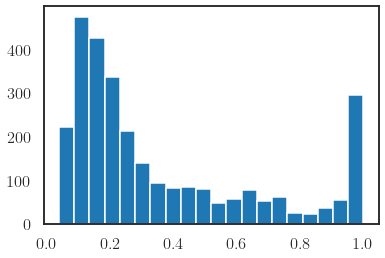

In [13]:
a = plt.hist(Prse_mean['SEM sum/mean sum'], bins=20)

Text(0.5, 0, 'log mean expression per gene')

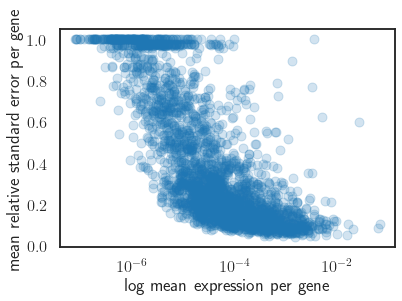

In [14]:
plt.plot(P_data.mean(axis=1), Prse_mean['mean RSE'], 'o', alpha=0.2)
plt.xscale('log')
plt.ylabel('mean relative standard error per gene')
plt.xlabel('log mean expression per gene')

#### B) Simulation Step 1: Definition of exemplary mRNA profiles

In [15]:
# define two mRNA profiles on [0,96] as functions
# no 1 peaks at the bottom of the villus
def mRNA_peak_bottom(t):
    loc = 0
    rv = norm(loc=loc/96, scale=0.2)
    # scale to 30 copies of mRNA per cell for a realistic scenario
    return 30*rv.pdf(t/96)/rv.pdf(loc/96)

# no 2 peaks towards the middle of the villus
def mRNA_peak_mid(t):
    loc = 30
    rv = norm(loc=loc/96, scale=0.35)
    # scale to 30 copies of mRNA per cell for a realistic scenario
    return 30*rv.pdf(t/96)/rv.pdf(loc/96)

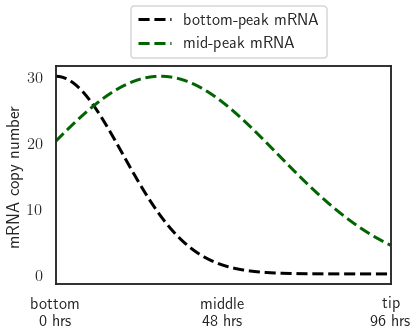

In [49]:
# plot params
lw = 3
plt.figure(figsize=(6,4))

plt.plot(np.linspace(0,96,100), mRNA_peak_bottom(np.linspace(0,96,100)), '--', color='black', label='bottom-peak mRNA', linewidth=lw)
plt.plot(np.linspace(0,96,100), mRNA_peak_mid(np.linspace(0,96,100)), '--', color='darkgreen', label='mid-peak mRNA', linewidth=lw)

plt.xlim([0,96])
#plt.ylim([0,1.1])
#plt.xlabel('villus spacetime')
plt.ylabel('mRNA copy number')
plt.xticks([0,48, 96])
#plt.yticks([0,1])
ax = plt.gca()
ax.set_xticklabels(['bottom \n 0 hrs', 'middle \n 48 hrs', 'tip \n 96 hrs'], rotation=0)

plt.legend(bbox_to_anchor=(0.2,1))
#sns.despine()
plt.savefig('figures/mRNA_profiles.pdf', bbox_inches='tight')

#### C) Simulation Step 2: Simulate corresponding protein curves

In [52]:
# smoothstep function for smoothly interpolating between two values of delta
from scipy.special import comb

def smoothstep(tvec, delta, phi, t_start=36, t_end=60):
    # produce step
    tvec = np.clip((tvec - t_start) / (t_end - t_start), 0, 1)
    
    # make step smooth
    result = 0
    if phi <= 1:
        for n in range(0, 3):
            result -= comb(2 + n, n) * comb(2 * 2 + 1, 2 - n) * (-tvec) ** n
        result *= tvec ** (2 + 1)
        result += 1
    else:
        for n in range(0, 3):
            result += comb(2 + n, n) * comb(2 * 2 + 1, 2 - n) * (-tvec) ** n        
        result *= tvec ** (2 + 1)
    
    # scale step to required values
    result = np.abs(delta*phi-delta)*result + np.min([delta, phi*delta])

    return result


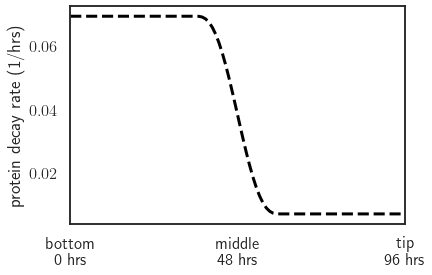

In [53]:
# plot params
lw = 3
plt.figure(figsize=(6,4))

plt.plot(np.linspace(0,96,100), smoothstep(np.linspace(0,96,100), np.log(2)/10, 0.1), '--', color='black', linewidth=lw)

plt.xlim([0,96])
#plt.ylim([0,1.1])
#plt.xlabel('villus spacetime')
plt.ylabel('protein decay rate (1/hrs)')
plt.xticks([0,48, 96])
#plt.yticks([0,1])
ax = plt.gca()
ax.set_xticklabels(['bottom \n 0 hrs', 'middle \n 48 hrs', 'tip \n 96 hrs'], rotation=0)

plt.savefig('figures/delta_smoothstep.pdf', bbox_inches='tight')

In [26]:
def protein_ODE(
        p,
        t,
        mRNA_fun,
        beta,
        delta,
        phi):
    """ Protein dynamics given current mRNA levels and translation,
    secretion and decay rates; model incorporates translation machinery
    decline. Decay rates in this version are non-constant, instead, there
    is one decay rate for the first half of the villus (delta) and one
    for the second half (phi*delta).
    """
    dp = beta * mRNA_fun(t) - smoothstep(t, delta, phi) * p
    return dp

In [27]:
def plot_P_M(tvec, mRNA_fun, protein_vec, norm=True):
    lw = 3
    plt.figure(figsize=(6,4))
    
    if norm:
        plt.plot(tvec, mRNA_fun(tvec)/np.mean(mRNA_fun(tvec)), '-', color='darkblue', label='mRNA', linewidth=lw)
        plt.plot(tvec, protein_vec/np.mean(protein_vec), '-', color='crimson', label='protein', linewidth=lw)
    else:
        plt.plot(tvec, mRNA_fun(tvec), '-', color='darkblue', label='mRNA', linewidth=lw)
        plt.plot(tvec, protein_vec, '-', color='crimson', label='protein', linewidth=lw)        

    plt.xlim([0,96])
    plt.ylabel('mean-normalized expression')
    plt.xticks([0,48, 96])
    ax = plt.gca()
    ax.set_xticklabels(['bottom \n 0 hrs', 'middle \n 48 hrs', 'tip \n 96 hrs'], rotation=0)
    # vertical line to indicate were rate switched
    plt.axvline(x=48, color='grey')

    plt.legend()

In [28]:
# simulate and plot some example protein curves
# general parameters
beta = 100  # proteins per mRNA per hour
tvec = np.linspace(0, 96, 97)

#### Examples for bottom-villus peak mRNA

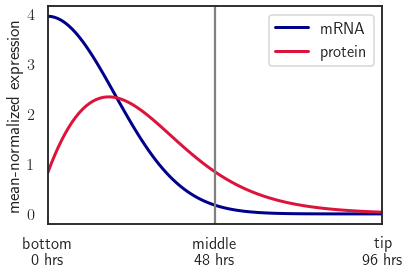

In [29]:
# mRNA 1 - constant delta, short life
p0 = 10000
delta = np.log(2)/10
phi = 1
protein_vec = odeint(protein_ODE, p0, tvec, args=(mRNA_peak_bottom, beta, delta, phi))
plot_P_M(tvec, mRNA_peak_bottom, protein_vec)

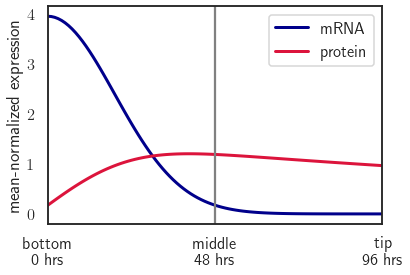

In [30]:
# mRNA 1 - constant delta, long life
p0 = 10000
delta = np.log(2)/150
phi = 1
protein_vec = odeint(protein_ODE, p0, tvec, args=(mRNA_peak_bottom, beta, delta, phi))
plot_P_M(tvec, mRNA_peak_bottom, protein_vec)

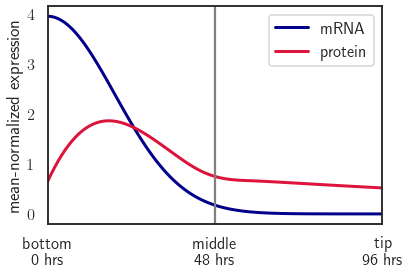

In [38]:
# mRNA 1 - short to longer life
p0 = 10000
delta = np.log(2)/10
phi = 1/10
protein_vec = odeint(protein_ODE, p0, tvec, args=(mRNA_peak_bottom, beta, delta, phi))
plot_P_M(tvec, mRNA_peak_bottom, protein_vec)
plt.savefig('figures/pure_sim_bottom_s2l.pdf', bbox_inches='tight')

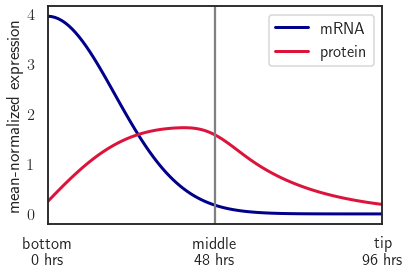

In [32]:
# mRNA 1 - long to shorter life
p0 = 10000
delta = np.log(2)/150
phi = 10
protein_vec = odeint(protein_ODE, p0, tvec, args=(mRNA_peak_bottom, beta, delta, phi))
plot_P_M(tvec, mRNA_peak_bottom, protein_vec)
plt.savefig('figures/pure_sim_bottom_l2s.pdf', bbox_inches='tight')

#### Examples for mid-villus peak mRNA

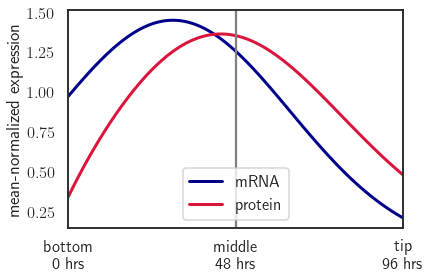

In [216]:
# mRNA 2 - constant delta, short life
p0 = 10000
delta = np.log(2)/10
phi = 1
protein_vec = odeint(protein_ODE, p0, tvec, args=(mRNA_peak_mid, beta, delta, phi))
plot_P_M(tvec, mRNA_peak_mid, protein_vec)

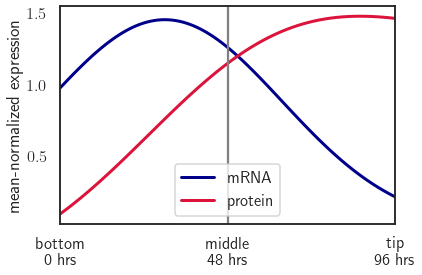

In [217]:
# mRNA 2 - constant delta, long life
p0 = 10000
delta = np.log(2)/150
phi = 1
protein_vec = odeint(protein_ODE, p0, tvec, args=(mRNA_peak_mid, beta, delta, phi))
plot_P_M(tvec, mRNA_peak_mid, protein_vec)

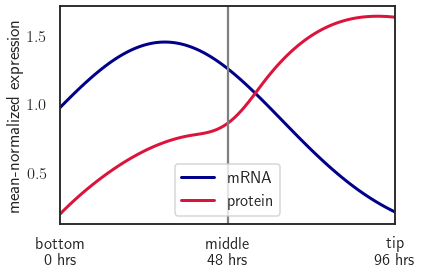

In [218]:
# mRNA 2 - short to longer life
p0 = 10000
delta = np.log(2)/10
phi = 0.1
protein_vec = odeint(protein_ODE, p0, tvec, args=(mRNA_peak_mid, beta, delta, phi))
plot_P_M(tvec, mRNA_peak_mid, protein_vec)
plt.savefig('figures/pure_sim_mid_s2l.pdf', bbox_inches='tight')

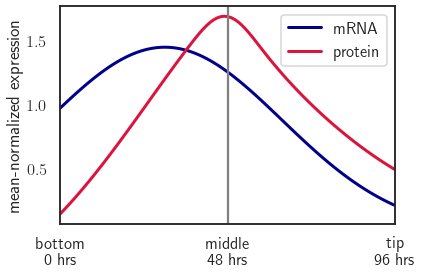

In [219]:
# mRNA 2 - long to shorter life
p0 = 10000
delta = np.log(2)/150
phi = 10
protein_vec = odeint(protein_ODE, p0, tvec, args=(mRNA_peak_mid, beta, delta, phi))
plot_P_M(tvec, mRNA_peak_mid, protein_vec)
plt.savefig('figures/pure_sim_mid_l2s.pdf', bbox_inches='tight')

#### D) Simulation Step 3: Protein measurements with noise 

In [220]:
# make a function that returns sampled protein mean and sem for input parameters
# together with 
def single_experiment(
        tvec,
        mRNA_type,  # 'bottom' or 'mid'
        p0,  # protein start value
        beta,  # translation rate per mRNA and hour
        delta,  # inital decay rate
        phi,  # factor for upper villus half decay rate
        noise_scale,  # magnitude of noise for drawing data points, give as fraction of base of value
        mice,  # number of inidividual data points to draw for mean and SEM calculation
        ):
    # generate name of the gene
    name  = mRNA_type + '_peak_halflife_{}_to_{}_h'.format(np.log(2)/delta, np.log(2)/(phi*delta))
    
    # get correct mRNA function
    if mRNA_type == 'mid':
        mRNA_fun = mRNA_peak_mid
    else:
        mRNA_fun = mRNA_peak_bottom
    
    # get mRNA values at the time points in tvec
    mRNA_vals = mRNA_fun(tvec)
    
    # get protein values at the time points
    protein_model = odeint(protein_ODE, p0, tvec, args=(mRNA_fun, beta, delta, phi)).T[0]
    
    # assuming Gaussian noise of magnitude 'noise', sample given number of times
    # and collect mean and sem for each villus zone
    protein_means = np.zeros(6)
    protein_sems = np.zeros(6)
    for zone in range(6):
        protein_vals = [] # list for collecting N simulated measurements
        for i in range(mice):
            # minimum value epsilon to avoid div by 0 issues downstream (and to avoid negative values due to gauss noise)
            protein_vals.append(np.max([1e-10, norm(loc=protein_model[zone], scale=protein_model[zone]*noise_scale).rvs()]))
        protein_means[zone] = np.mean(protein_vals)
        protein_sems[zone] = np.std(protein_vals, ddof=1)/np.sqrt(mice)
        
    
    return name, mRNA_fun, mRNA_vals, protein_model, protein_means, protein_sems

#### Exploration of the relationship between noise scale and resulting relative standard error for en experiment with 4 mice

(0.0, 1.0)

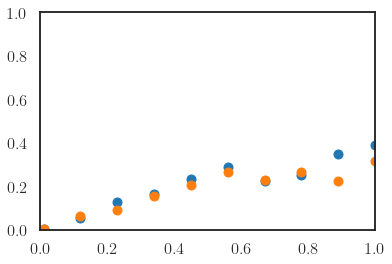

In [226]:
test_scales = np.linspace(0.01, 1, 10)
plt.figure()
for i in range(2):
    rse_coll = []
    for noise in test_scales:
        names, mRNA_fun, mRNA_vals, protein_model, protein_means, protein_sems = single_experiment(np.linspace(0, 96, 6), 'bottom', 10000, beta, np.log(2)/150, 3, noise, 4)
        rse_coll.append(np.mean(protein_sems/protein_means))
    plt.plot(test_scales, rse_coll, 'o')
plt.xlim(left=0, right=1)
plt.ylim(bottom=0, top=1)

(0.0, 1.0)

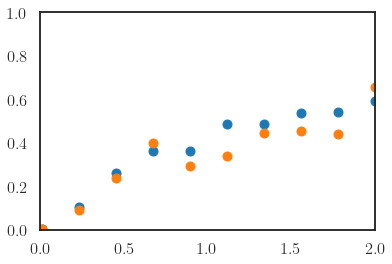

In [222]:
test_scales = np.linspace(0.01, 2, 10)
plt.figure()
for i in range(2):
    rse_coll = []
    for noise in test_scales:
        names, mRNA_fun, mRNA_vals, protein_model, protein_means, protein_sems = single_experiment(np.linspace(0, 96, 6), 'bottom', 10000, beta, np.log(2)/150, 1, noise, 4)
        rse_coll.append(np.mean(protein_sems/protein_means))
    plt.plot(test_scales, rse_coll, 'o')
plt.xlim(left=0, right=2)
plt.ylim(bottom=0, top=1)

(0.0, 1.0)

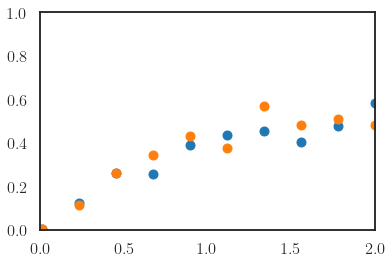

In [223]:
test_scales = np.linspace(0.01, 2, 10)
plt.figure()
for i in range(2):
    rse_coll = []
    for noise in test_scales:
        names, mRNA_fun, mRNA_vals, protein_model, protein_means, protein_sems = single_experiment(np.linspace(0, 96, 6), 'mid', 10000, beta, np.log(2)/150, 1, noise, 4)
        rse_coll.append(np.mean(protein_sems/protein_means))
    plt.plot(test_scales, rse_coll, 'o')
plt.xlim(left=0, right=2)
plt.ylim(bottom=0, top=1)

(0.0, 1.0)

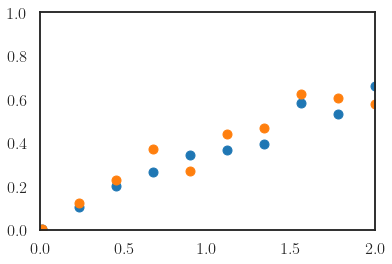

In [224]:
test_scales = np.linspace(0.01, 2, 10)
plt.figure()
for i in range(2):
    rse_coll = []
    for noise in test_scales:
        names, mRNA_fun, mRNA_vals, protein_model, protein_means, protein_sems = single_experiment(np.linspace(0, 96, 6), 'mid', 10000, beta, np.log(2)/15, 0.2, noise, 4)
        rse_coll.append(np.mean(protein_sems/protein_means))
    plt.plot(test_scales, rse_coll, 'o')
plt.xlim(left=0, right=2)
plt.ylim(bottom=0, top=1)

(0.0, 1.0)

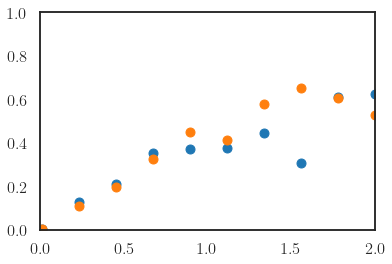

In [225]:
test_scales = np.linspace(0.01, 2, 10)
plt.figure()
for i in range(2):
    rse_coll = []
    for noise in test_scales:
        names, mRNA_fun, mRNA_vals, protein_model, protein_means, protein_sems = single_experiment(np.linspace(0, 96, 6), 'bottom', 10000, beta, np.log(2)/10, 0.5, noise, 4)
        rse_coll.append(np.mean(protein_sems/protein_means))
    plt.plot(test_scales, rse_coll, 'o')
plt.xlim(left=0, right=2)
plt.ylim(bottom=0, top=1)

#### E) Simulation Step 4: Generation of data in target RSE areas

In [237]:
# we want to generate simulated data with relative standard errors
# from within the following ranges
RSE_targets = [[0.04, 0.06],
               [0.09, 0.11],
               [0.14, 0.16],
               [0.19, 0.21],
               [0.24, 0.26],
               [0.29, 0.31],
               [0.38, 0.42],
               [0.48, 0.52]]

In [238]:
N_repeats = 100 # how many repeats per target range

# constant parameters for all runs
p0 = 10000  # protein start value
beta = 100  # translation rate per mRNA and hour
mice = 4

# variable parameter sets for short-->long halflife
mRNA_type = ['bottom', 'mid']
delta = [np.log(2)/10]
phis = [1, 2/3, 1/2, 1/3, 1/5, 1/10]
# combinations of these
s2l_params = list(product(mRNA_type, delta, phis))

# variable parameter sets for long-->short halflife
mRNA_type = ['bottom', 'mid']
delta = [np.log(2)/150]
phis = [1, 3/2, 2, 3, 5, 10]
# combinations of these
l2s_params = list(product(mRNA_type, delta, phis))

# combine two lists
all_params = s2l_params + l2s_params

In [239]:
# loop until required number of data sets have been simulated
data_collection = []
# go through all parameter combinations defined above
for i, pc in enumerate(all_params):
    # unpack
    print(i, pc)
    mRNA_type, delta, phi = pc
    # array of counters for each of the target zones
    target_counters = np.zeros(len(RSE_targets))
    # generate data for this parameter set
    while True:
        noise = np.random.rand()*2
        # run a simulation as specified
        name, mRNA_fun, mRNA_vals, protein_model, protein_means, protein_sems = \
            single_experiment(np.linspace(0, 96, 6), mRNA_type, p0, beta, delta,\
                              phi, noise, mice)
        # calculate the mean RSE for this
        RSE = np.mean(protein_sems/protein_means)
        # check if it falls into one of the target ranges
        # and the counter of that range is not yet full
        for i, tr in enumerate(RSE_targets):
            if (tr[0] <= RSE <= tr[1]) and (target_counters[i] < N_repeats):
                print('hit', tr)
                # increase the counter
                target_counters[i] += 1
                # edit the name to indicate noise and number of repeat
                name += '_RSE_{}_rep{}'.format(tr, target_counters[i])
                # store the data
                data_collection.append((name, mRNA_fun, mRNA_vals, protein_model, protein_means, protein_sems))
                # and exit this loop
                break
        # after each repeat, check if all counters are satisfied
        if np.all(target_counters == N_repeats):
            break

0 ('bottom', 0.06931471805599453, 1)
hit [0.48, 0.52]
hit [0.29, 0.31]
hit [0.19, 0.21]
hit [0.29, 0.31]
hit [0.14, 0.16]
hit [0.48, 0.52]
hit [0.29, 0.31]
hit [0.29, 0.31]
hit [0.48, 0.52]
hit [0.38, 0.42]
hit [0.19, 0.21]
hit [0.38, 0.42]
hit [0.38, 0.42]
hit [0.04, 0.06]
hit [0.29, 0.31]
hit [0.48, 0.52]
hit [0.24, 0.26]
hit [0.04, 0.06]
hit [0.48, 0.52]
hit [0.38, 0.42]
hit [0.48, 0.52]
hit [0.09, 0.11]
hit [0.29, 0.31]
hit [0.38, 0.42]
hit [0.48, 0.52]
hit [0.29, 0.31]
hit [0.38, 0.42]
hit [0.09, 0.11]
hit [0.48, 0.52]
hit [0.19, 0.21]
hit [0.38, 0.42]
hit [0.48, 0.52]
hit [0.48, 0.52]
hit [0.09, 0.11]
hit [0.48, 0.52]
hit [0.38, 0.42]
hit [0.38, 0.42]
hit [0.04, 0.06]
hit [0.48, 0.52]
hit [0.38, 0.42]
hit [0.04, 0.06]
hit [0.38, 0.42]
hit [0.04, 0.06]
hit [0.38, 0.42]
hit [0.48, 0.52]
hit [0.38, 0.42]
hit [0.38, 0.42]
hit [0.29, 0.31]
hit [0.38, 0.42]
hit [0.48, 0.52]
hit [0.38, 0.42]
hit [0.19, 0.21]
hit [0.48, 0.52]
hit [0.48, 0.52]
hit [0.38, 0.42]
hit [0.48, 0.52]
hit [0.48, 

In [240]:
# list of gene names
gene_list = []
# data arrays for mRNA, protein mean and sem
mRNA_array = np.empty((len(data_collection), 6))
Pmean_array = np.empty((len(data_collection), 6))
Psem_array = np.empty((len(data_collection), 6))
Pmodel_array = np.empty((len(data_collection), 6))

# go through data collection and extract all relevant data
for i, result in enumerate(data_collection):
    # in the gene name, we need to replace comma by sth else to avoid split issues later
    new_name = result[0].replace(', ', '_')
    gene_list.append(new_name)
    mRNA_array[i, :] = result[2]
    Pmodel_array[i, :] = result[3]
    Pmean_array[i, :] = result[4]
    Psem_array[i, :] = result[5]

In [241]:
# mold the data into dataframes and sort
M_data = pd.DataFrame(data=mRNA_array, columns=['V{}'.format(i) for i in range(1, 7)], index=gene_list).sort_index()
P_data = pd.DataFrame(data=Pmean_array, columns=['V{}'.format(i) for i in range(1, 7)], index=gene_list).sort_index()
Psem_data = pd.DataFrame(data=Psem_array, columns=['V{}'.format(i) for i in range(1, 7)], index=gene_list).sort_index()
Pmodel_data = pd.DataFrame(data=Pmodel_array, columns=['V{}'.format(i) for i in range(1, 7)], index=gene_list).sort_index()

In [242]:
# next, get linear interpolation of the mRNA profiles (like in real fit process)
# define time values in hours
time_vec = np.linspace(0, 96, 6)
# let's store the interpolation functions in a dict
M_interp_dict = {}
# go through all genes, get the interp function, write it to dict
for gene in M_data.index.tolist():
    # interpolate
    M_this_fun = interp1d(time_vec, M_data.loc[gene].tolist(),
                          kind='slinear', fill_value='extrapolate')
    # store
    M_interp_dict[gene] = M_this_fun

In [243]:
# export these dataframes to the processed data folder
output_folder = 'processed_data'
M_data.to_csv(output_folder+"/M_data_sc_based_scaled.csv",
                       index=True, header=True)
P_data.to_csv(output_folder+"/P_data_vol_corrected_scaled.csv",
                       index=True, header=True)
Psem_data.to_csv(output_folder+"/Psem_data_vol_corrected_scaled.csv",
                          index=True, header=True)
Pmodel_data.to_csv(output_folder+"/Pmodel_data_vol_corrected_scaled.csv",
                          index=True, header=True)
# pickle the dict to file
with open(output_folder+"/M_interp_dict", 'wb') as file:
    pickle.dump(M_interp_dict, file)
    
# finally, also pickle to file a list of all gene names to facilitate
# cluster job distribution
gene_names = M_data.index.tolist()
with open("processed_data/gene_names", 'wb') as file:
    pickle.dump(gene_names, file)
# in order to automatically write cluster jobs elsewhere, make csv of gene names as well
import csv
with open("processed_data/gene_names.csv", 'w') as file:
    for word in gene_names:
        file.write(word + ' ')